# The goal here is to benchmark the DpoDetection tool with other depolymerase detection tools 
***
# I. Load the models :
#### 77 phages candidates 
>Detected Dpos <br>
>Missed Dpos <br>
***
# II. Getting the resulting predictions
#### Pires Dpos

***
# III. Make figures
***

I.
> Make the predictions : DpoDetection Tool :

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/DepoDetection.S1.conv.model \
/media/concha-eloko/Linux/depolymerase_building

In [1]:
50*30*30

45000

In [20]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

#esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_3/checkpoint-6015"
#DpoDetection_path = f"{path_work}/DepoDetection.T12.3Labels.1908.model"

#esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4/checkpoint-6015"
#DpoDetection_path = f"{path_work}/DepoDetection.T12.4Labels.1908.model"

esm2_model_path = f"{path_work}/esm2_t6_8M_UR50D-finetuned-depolymerase.labels_4/checkpoint-6015"
DpoDetection_path = f"{path_work}/DepoDetection.T6.4Labels.1908.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)


In [21]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 1)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs


In [22]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 320, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
        (position_embeddings): Embedding(1026, 320, padding_idx=1)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-5): 6 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=320, out_features=320, bias=True)
                (key): Linear(in_features=320, out_features=320, bias=True)
                (value): Linear(in_features=320, out_features=320, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=320, out_features=320, bias=True)
                (dropout): Dropout(p=0.0, inplace

In [23]:
def predict_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = [sequence]  # Wrap the sequence in a list to match the model's input format
        outputs, sequence_outputs = model(sequence)
        probas = torch.sigmoid(outputs)  # Apply sigmoid activation for binary classification
        predictions = (probas > 0.5).float()  # Convert probabilities to binary predictions
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]
        prob_predicted = probas[0].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list


def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        elif tokens[i] == 2:
            color = 'red'
        else :
            color = 'green'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

In [28]:
input_fasta = "MGLHVQKSQLSVIKLGDYGAVGDGVTDDTTSFINLEAEHKGKIINLEFKTYLVDKGFSGNFYINGSFKVGDNTFAAPYTLPYANNSNIFMGENSGVNTDKYPVYMASAGGYSNIGIGKNALKSNTEGWRNVAIGDGALVNNTLGHYNIAVGDEALRDNIGSRNGDSTDNGSRNTAVGSNTMCYNTTGYCNTAMGRNALHTNFTGYHNTAIGAAALSGNAPYVNGVVVPDDPKHGNYNTAVGSEALFRGNSDHNTAVGRSAAWNTKNGARNVAIGSEALYYNEANVTYDDKTTAGAGNTAVGTAAMKYMQDGSQATLVNNSSAIGYGARVSGDNQVQLGGSGTTTYSYGAVQSRSDQRDKTDIKDTELGLDFLLKVRPVDFRWDYRDDYQEIDEEGNLITHEKDGSRSGNRFHHGVIAQEIQEVIQKTGKDFGGLQDHKINGGTDVLSIGYEEFIAPIIKSIHELHKMVSDLSDRISELENK"

prediction , token = predict_sequence(model_classifier ,input_fasta)

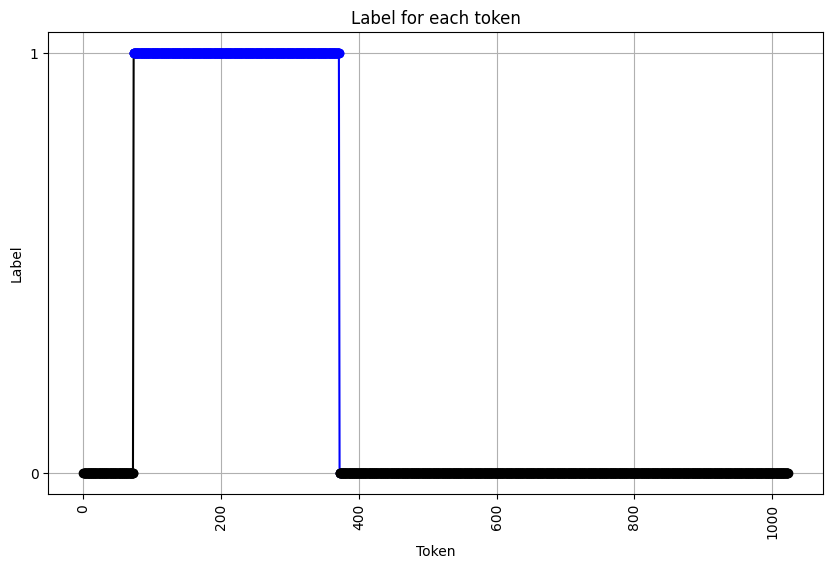

((1.0, 1.0), None)

In [29]:
prediction  , plot_token(token)

***
# VS Pires 2016

In [24]:
class Dpo_model_pred:
    def __init__(self, name, tokens, prediction, sequence):
        self.name = name
        self.tokens = tokens
        self.prediction = prediction
        self.sequence = sequence
        
    def plot_token(self) :
        tokens = np.array(self.tokens)  
        plt.figure(figsize=(10,6))
        for i in range(len(tokens) - 1):
            if tokens[i] == 0:
                color = 'black'
            elif tokens[i] == 1:
                color = 'blue'
            elif tokens[i] == 2:
                color = 'red'
            else:
                color = 'green'
            plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
        plt.xlabel('Token')
        plt.ylabel('Label')
        plt.title('Label for each token')
        plt.xticks(rotation='vertical')
        plt.yticks(np.arange(2), ['0', '1'])  
        plt.grid(True)
        plt.show()

    def get_prediction(self):
        return self.prediction
    
    def get_seq(self):
        return self.sequence



> Get the other tools results

Make the predictions 

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking/benchmark_dataframe.csv \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb \


In [3]:
import pandas as pd 
import os 
from tqdm import tqdm
from Bio import SeqIO

path_DePP_results = "/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking"
df_results = pd.read_csv(f"{path_DePP_results}/benchmark_dataframe.csv", header = 0 )


In [4]:
seq_to_remove = SeqIO.parse(f"{path_DePP_results}/remove_benchmark.fasta", "fasta")
seq_to_remove_list = [record.seq for record in seq_to_remove]

In [27]:
%%time
#output_label_DepolyX = []

all_lengths = 0
for seq in tqdm(df_results["protein_seq"][0:1000]) : 
    prediction, sequence_outputs = predict_sequence(model_classifier, seq)
    all_lengths = all_lengths + len(seq)
    #output_label_DepolyX.append(prediction)


100%|███████████████████████████████████████| 1000/1000 [01:10<00:00, 14.14it/s]

CPU times: user 4min 10s, sys: 31.5 s, total: 4min 42s
Wall time: 1min 10s


In [28]:
from pympler import asizeof

size_in_bytes = asizeof.asizeof((model_classifier), "bytes")
size_in_kb = size_in_bytes / 1024
size_in_mb = size_in_bytes / (1024 ** 2)

size_in_kb

331.3359375

In [5]:
#scores_DepolyX = [pred[1] for _,pred in enumerate(output_label_DepolyX)]
#df_results["scores_DepolyX"] = scores_DepolyX
#df_results.to_csv(f"{path_DePP_results}/full_benchmark_dataframe.3L.2008.csv", sep = ",", index = False)

df_final_results = pd.read_csv(f"{path_DePP_results}/full_benchmark_dataframe.4L.2008.csv", header = 0, sep = ",")
df_final_results = df_final_results[df_final_results["protein_seq"].str.len() >= 200]

df_final_results_unseen = df_final_results[~df_final_results["protein_seq"].isin(seq_to_remove_list)]


In [6]:
genomes_id = df_final_results_unseen["genome_id"].unique().tolist()

def get_metrics(df, tool_score , threshold) : 
    tp , tn , fp , fn = 0 , 0 , 0 , 0
    for _,row in df.iterrows() : 
        if row["label"] == 0 : 
            if row[tool_score] >= threshold : 
                fp += 1 
            else :
                tn += 1 
        else :
            if row[tool_score] >= threshold : 
                tp += 1 
            else :
                fn += 1 
    return [tp , tn , fp , fn]
    
metrics = {}
for _,genome in enumerate(genomes_id) :  
    #df_genome = df_results[(df_results["genome_id"] == genome) & (len(df_results["protein_seq"]) >= 200)]
    df_genome = df_final_results_unseen[(df_final_results_unseen["genome_id"] == genome)]
    metric_phageDPO = get_metrics(df_genome , "scores_phageDPO" , 50)
    metric_DePP = get_metrics(df_genome , "scores_DePP" , 0.5)
    metric_DepolyX = get_metrics(df_genome , "scores_DepolyX" , 0.5)
    a = {"phageDPO" : metric_phageDPO , "DePP" : metric_DePP, "DepolyX" : metric_DepolyX}
    metrics[genome] = a

In [7]:
import json
import pprint
pp = pprint.PrettyPrinter(width = 100, sort_dicts = True, compact = True)
pp.pprint(metrics)

{'AY349011.3': {'DePP': [1, 21, 5, 0], 'DepolyX': [1, 24, 2, 0], 'phageDPO': [1, 24, 2, 0]},
 'CP000711.1': {'DePP': [0, 13, 5, 0], 'DepolyX': [0, 18, 0, 0], 'phageDPO': [0, 17, 1, 0]},
 'DQ831957.1': {'DePP': [0, 10, 9, 0], 'DepolyX': [0, 19, 0, 0], 'phageDPO': [0, 13, 6, 0]},
 'DQ834250.1': {'DePP': [1, 11, 8, 0], 'DepolyX': [1, 19, 0, 0], 'phageDPO': [1, 14, 5, 0]},
 'FQ482084.1': {'DePP': [1, 10, 10, 0], 'DepolyX': [1, 19, 1, 0], 'phageDPO': [1, 18, 2, 0]},
 'FR671405.1': {'DePP': [1, 5, 5, 0], 'DepolyX': [0, 10, 0, 1], 'phageDPO': [0, 9, 1, 1]},
 'FR671406.1': {'DePP': [1, 8, 7, 0], 'DepolyX': [0, 15, 0, 1], 'phageDPO': [0, 14, 1, 1]},
 'FR671407.1': {'DePP': [1, 10, 5, 0], 'DepolyX': [0, 15, 0, 1], 'phageDPO': [0, 14, 1, 1]},
 'FR671410.1': {'DePP': [1, 7, 5, 0], 'DepolyX': [0, 12, 0, 1], 'phageDPO': [0, 11, 1, 1]},
 'FR671411.1': {'DePP': [1, 6, 5, 0], 'DepolyX': [0, 11, 0, 1], 'phageDPO': [0, 10, 1, 1]},
 'GQ413937.1': {'DePP': [1, 7, 8, 0], 'DepolyX': [1, 13, 2, 0], 'phageDPO'

In [8]:
df_final_results_unseen

,genome_id,protein_id,dna_seq,protein_seq,label,scores_phageDPO,scores_DePP,scores_DepolyX
0,KC821630.1,AGO49320,ATGGCTTTACATACTAGAAAAGAGTTCGCTGCTCTATGCAGAACAA...,MALHTRKEFAALCRTTIAVVNTNVNRNKIQLHDKKIDSQNAINKKF...,0,0.0,0.243067,0.019835
3,KC821630.1,AGO49323,ATGAATTTAAAAGATATTTGGAAACAGCAGTTAAATTTTTTCAATT...,MNLKDIWKQQLNFFNSKLYSYKTIKAIPSEWVEKTIILDPEVSRFS...,0,21.0,0.852377,0.019835
5,KC821630.1,AGO49325,ATGAGTTTTAAAGAAAATTGGAATAAGTTTACTGAAGTTTTCTTAG...,MSFKENWNKFTEVFLGKETQQASSSSPYYNEANDGRSYNPIIDDLF...,0,32.0,0.799602,0.019835
7,KC821630.1,AGO49327,ATGAAAAATTATTTGTCAATTTTATTTTTGCTTTCAAGCTTTTTAG...,MKNYLSILFLLSSFLVLSQNPTSFRNGVIPGVKTTAEIQAIVSPKL...,0,82.0,0.764837,0.019835
10,KC821630.1,AGO49330,ATGAATTTTCCCCGAATCAAGAGCTTTATCAAAAAGTCGAATTATA...,MNFPRIKSFIKKSNYKRRILLVRLRCVKRLIRQKIWIRKIIRSKVL...,0,2.0,0.277224,0.019835
...,...,...,...,...,...,...,...,...
17824,NC_048631.1,YP_009829900,ATGAGAATGAAAAAGATTCTTTTAATTTGTGTTCCCTTCGTAATTT...,MRMKKILLICVPFVILAVAASLYFFNKDQNKQTSAVTDDEKYNDEQ...,0,8.0,0.516787,0.019835
17826,NC_048631.1,YP_009829902,ATGCTAGAATATTGTTTGAGAAAATTTAGAATATTTGTAGAAAGAG...,MLEYCLRKFRIFVERGVYLMSKLASECVANILNDWYIAIKQQDAES...,0,0.0,0.386534,0.019835
17827,NC_048631.1,YP_009829903,ATGAACTTGATGGATGAAAACACTCCAAAGAATGTCGGGATATACG...,MNLMDENTPKNVGIYVRVSTEEQAKEGYSISAQKEKLKAYCISQGW...,0,1.0,0.524053,0.019835
17835,NC_048631.1,YP_009829911,ATGTTTCAAGTAACAGACGCGCAACGTCAAAAGGAAAAAGCAATTG...,MFQVTDAQRQKEKAIVGFIGPSGSGKTAGALLVAYGMMQEAYPDAS...,0,1.0,0.384229,0.019835


In [13]:
from collections import Counter 
Counter(df_final_results_unseen["label"])

Counter({0: 5377, 1: 83})

In [15]:
83/5377*100

1.5436116793751162

In [9]:
data_dict = {"Deposcope" : df_final_results_unseen["scores_DepolyX"], 
             "PhageDPO" : (df_final_results_unseen["scores_phageDPO"]/100), 
             "DePP" : df_final_results_unseen["scores_DePP"], 
             "Label" : df_final_results_unseen["label"]}

data_color = {"Deposcope" : "#b22234", 
             "PhageDPO" : "#3c3b6e", 
             "DePP" : "#828282"}

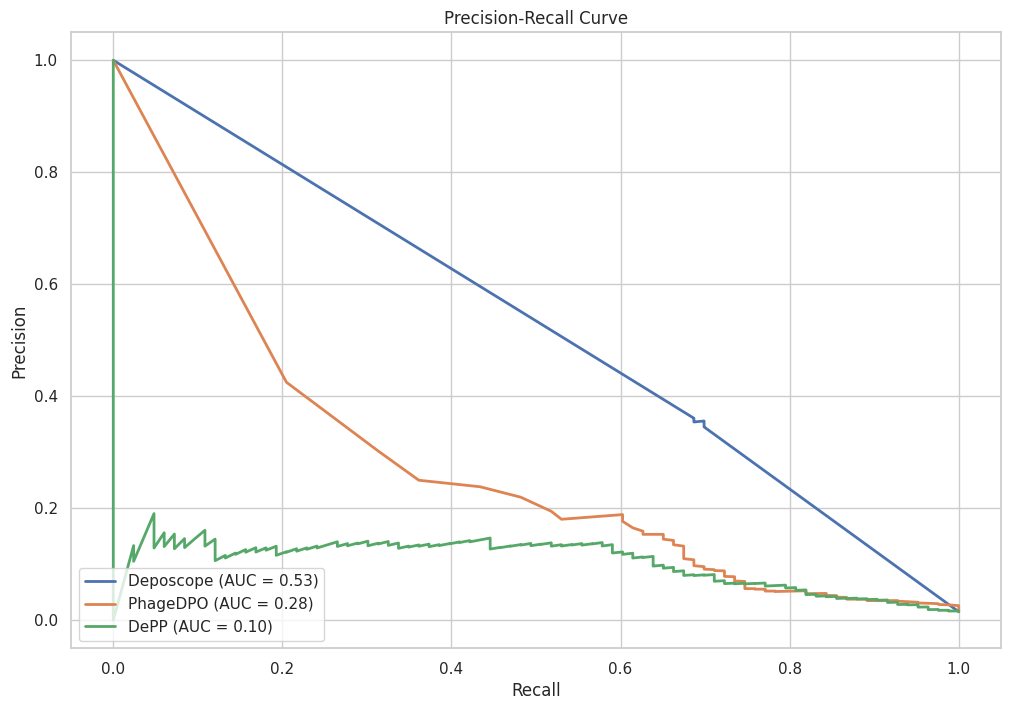

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

def plot_multiple_precision_recall_curves(data_dict):
    plt.figure(figsize=(12, 8))
    lw = 2
    sns.set(style="whitegrid")
    for key, value in data_dict.items():
        if key != "Label":
            precision, recall, _ = precision_recall_curve(data_dict["Label"], value)
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=lw, label=f'{key} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig('/media/concha-eloko/Linux/papers/Deposcope/Precision_Recall_methods.1303.png', dpi=500)
    plt.show()

plot_multiple_precision_recall_curves(data_dict)

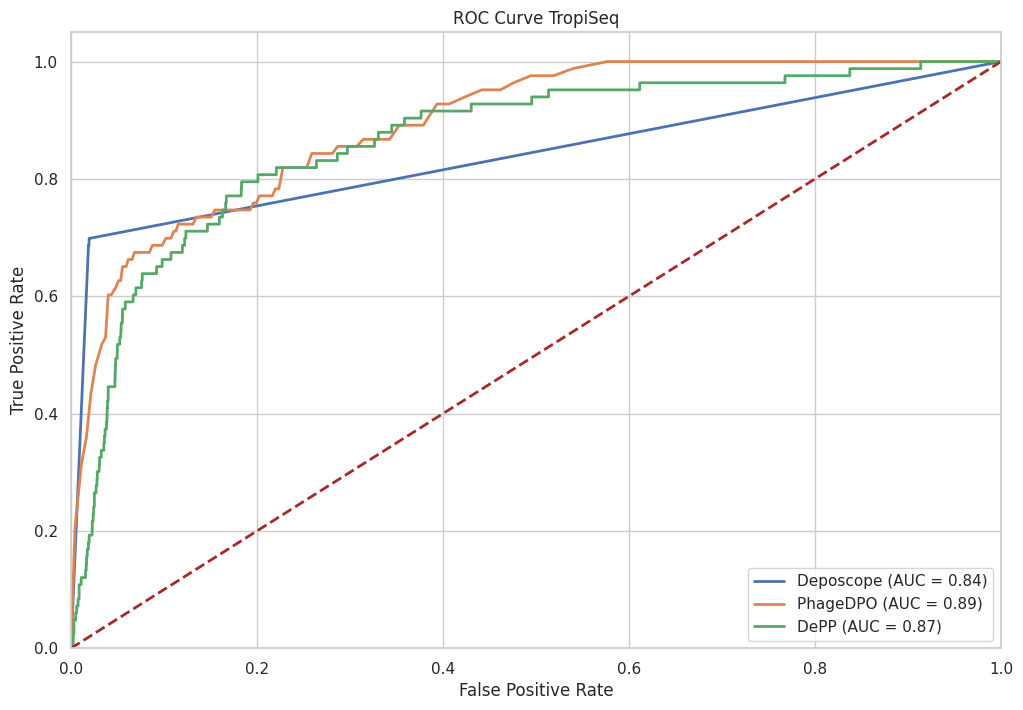

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def plot_multiple_roc_curves(data_dict):
    plt.figure(figsize=(12, 8))
    lw = 2
    sns.set(style="whitegrid")
    for key, value in data_dict.items():
        if key != "Label" :
            fpr, tpr, _ = roc_curve(data_dict["Label"], value)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=lw, label=f'{key} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='brown', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve TropiSeq')
    plt.legend(loc="lower right")
    plt.savefig('/media/concha-eloko/Linux/papers/Deposcope/ROC_methods.1303.svg', dpi=500)
    plt.show()

plot_multiple_roc_curves(data_dict)

> Save the metric df

In [12]:
flat_data = {}
for outer_key, inner_dict in metrics.items():
    for inner_key, inner_list in inner_dict.items():
        for i, value in enumerate(inner_list):
            col_name = f'{inner_key}_{i}'
            flat_data.setdefault(outer_key, {})[col_name] = value

# Create the DataFrame
df = pd.DataFrame.from_dict(flat_data, orient='index')
df.to_csv(f"{path_DePP_results}/benchmark_dataframe.metrics1.4L.1103.csv", sep = "\t", index = True)


In [18]:
full_metric = {}

metric_phageDPO = get_metrics(df_final_results_unseen , "scores_phageDPO" , 50)
metric_DePP = get_metrics(df_final_results_unseen , "scores_DePP" , 0.5)
metric_DepolyX = get_metrics(df_final_results_unseen , "scores_DepolyX" , 0.5)

full_metric = {"DePP" : metric_DePP, "phageDPO" : metric_phageDPO , "DepolyX" : metric_DepolyX}
full_metric

{'DePP': [76, 3275, 2102, 7],
 'phageDPO': [62, 4412, 965, 21],
 'DepolyX': [58, 5270, 107, 25]}

In [ ]:
{'DePP': [147, 15593, 2103, 8],
 'phageDPO': [133, 16649, 1047, 22],
 'DepolyX': [127, 17574, 122, 28]}

In [33]:
full_metric = {'DePP': [147, 3275, 2103, 8],
 'phageDPO': [133, 4412, 966, 22],
 'DepolyX': [127, 5270, 108, 28],
'DepolyX_corrected' : [127, 5270,8,28]}

In [24]:
full_metric_unseen = {'DePP': [76, 3275, 2102, 7],
 'phageDPO': [62, 4412, 965, 21],
 'DepolyX': [58, 5270, 107, 25],
 'DepolyX_corrected' : [58, 5270,8,25]}

In [8]:
df_metric_1 = pd.DataFrame(metrics)
df_metric_1

,KC821630.1,NC_019454.1,NC_020842.1,NC_019917.1,NC_021856.1,FR671410.1,FR671406.1,NC_009819.1,NC_017980.1,KC556894.1,...,NC_020478.1,NC_009014.1,NC_024211.1,CP000711.1,NC_017981.1,NC_001423.1,NC_024137.1,NC_017972.1,NC_020078.1,NC_048631.1
phageDPO,"[1, 74, 6, 0]","[1, 52, 2, 0]","[1, 95, 8, 0]","[1, 73, 1, 0]","[0, 205, 12, 2]","[0, 51, 1, 1]","[0, 55, 1, 1]","[1, 48, 4, 0]","[1, 23, 2, 0]","[1, 53, 4, 0]",...,"[1, 74, 4, 0]","[1, 49, 3, 0]","[1, 280, 9, 0]","[1, 60, 1, 0]","[1, 75, 5, 0]","[1, 23, 3, 0]","[1, 216, 12, 0]","[0, 370, 20, 1]","[1, 47, 1, 0]","[1, 49, 2, 0]"
DePP,"[1, 65, 15, 0]","[1, 46, 8, 0]","[1, 89, 14, 0]","[1, 68, 6, 0]","[1, 194, 23, 1]","[1, 47, 5, 0]","[1, 49, 7, 0]","[0, 39, 13, 1]","[1, 21, 4, 0]","[1, 50, 7, 0]",...,"[1, 73, 5, 0]","[1, 42, 10, 0]","[1, 268, 21, 0]","[1, 56, 5, 0]","[1, 75, 5, 0]","[1, 20, 6, 0]","[1, 198, 30, 0]","[0, 345, 45, 1]","[1, 41, 7, 0]","[1, 42, 9, 0]"
DepolyX,"[1, 79, 1, 0]","[1, 53, 1, 0]","[0, 103, 0, 1]","[1, 73, 1, 0]","[1, 216, 1, 1]","[0, 52, 0, 1]","[0, 56, 0, 1]","[1, 52, 0, 0]","[1, 25, 0, 0]","[1, 56, 1, 0]",...,"[1, 78, 0, 0]","[1, 51, 1, 0]","[1, 289, 0, 0]","[1, 61, 0, 0]","[1, 80, 0, 0]","[1, 26, 0, 0]","[1, 228, 0, 0]","[0, 389, 1, 1]","[1, 47, 1, 0]","[1, 51, 0, 0]"


In [15]:
def get_precision(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return tp/(tp + fp)
    
def get_recall(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return tp/(tp + fn)

def F1_score(metric) : 
    precision = get_precision(metric)
    recall = get_recall(metric)
    return 2*(precision*recall) / (precision + recall)

def accuracy_score(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return (tp + tn)/(tp + tn + fp + fn)

def specificity_score(metric) :
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return tn /(tn + fp)


def MCC(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    mcc = (tp*tn - fp*fn)/((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))**0.5
    return mcc

In [30]:
#print("precision\trecall\taccuracy\tf1\tMCC\tspecificity")
for tool in full_metric_unseen:
    print(tool)
    print(round(get_precision(full_metric_unseen[tool]), 4), 
          round(get_recall(full_metric_unseen[tool]), 4), 
          round(specificity_score(full_metric_unseen[tool]), 4), 
          round(accuracy_score(full_metric_unseen[tool]), 4), 
          round(F1_score(full_metric_unseen[tool]), 4), 
          round(MCC(full_metric_unseen[tool]), 4), 
          sep="\t")



DePP
0.0349	0.9157	0.6091	0.6137	0.0672	0.1311
phageDPO
0.0604	0.747	0.8205	0.8194	0.1117	0.1777
DepolyX
0.3515	0.6988	0.9801	0.9758	0.4677	0.4852
DepolyX_corrected
0.8788	0.6988	0.9985	0.9938	0.7785	0.7807


***

# Investigating the results : 

### The FP : 

In [23]:
import os 
from Bio import SeqIO
from collections import Counter

path_fp_seq = "/media/concha-eloko/Linux/PhageDEPOdetection"
pdb_source = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108"
pdb_destination = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108_pt2"

fp_dico = {record.seq : record.id for record in SeqIO.parse(f"{path_fp_seq}/Dpos_reference.T12_FP.multi.fasta", "fasta")}
fp_dico_2 = {record.seq : record.id for record in SeqIO.parse(f"{path_fp_seq}/T12.FP.multi_new.pt2.2008.fasta", "fasta")}
fp_dico_3 = {record.seq : record.id for record in SeqIO.parse(f"{path_fp_seq}/T12.FP.multi_new.2008.fasta", "fasta")}
#fp_dico_r = {record.id : record.seq for record in SeqIO.parse(f"{path_fp_seq}/Dpos_reference.T12_FP.multi.fasta", "fasta")}
fp_dico.update(fp_dico_2)
fp_dico.update(fp_dico_3)


FP_sequences = []

weird = 0 
weird_seq = set()
done = 0 
done_names = []
to_do = 0

done_seqs = set()
FP = []
for _,row in df_final_results.iterrows() : 
    if row["label"] == 0 and row["scores_DepolyX"] > 0.5 : 
        FP_sequences.append(row["protein_seq"])
        if row["protein_seq"] in list(fp_dico.keys()) :
            FP.append(fp_dico[row["protein_seq"]])

In [30]:
fp_pdb = [f"{file}.pdb" if file.count("|")==0 else f"{file.split('|')[1]}.pdb" for file in FP]
fp_pdb

['0__pt2.pdb',
 'NC_019454.1_prot_YP_007002897.1_44.pdb',
 'NC_019917.1_prot_YP_007236809.1_63.pdb',
 '6__FP__T12.pdb',
 'KC556894.1_prot_AHB81137.1_21.pdb',
 'NC_022772.1_prot_YP_008771658.1_40.pdb',
 'NC_022772.1_prot_YP_008771659.1_41.pdb',
 'NC_027364.1_prot_YP_009150315.1_1.pdb',
 'NC_027364.1_prot_YP_009150385.1_71.pdb',
 'NC_027364.1_prot_YP_009150600.1_286.pdb',
 '9__pt2.pdb',
 'NC_027364.1_prot_YP_009150602.1_288.pdb',
 '11__pt2.pdb',
 '12__pt2.pdb',
 '13__pt2.pdb',
 'NC_027364.1_prot_YP_009150606.1_292.pdb',
 '15__pt2.pdb',
 '16__pt2.pdb',
 '17__pt2.pdb',
 'NC_022770.1_prot_YP_008771333.1_15.pdb',
 'FJ230960.1_prot_ACI90966.1_61.pdb',
 '20__pt2.pdb',
 'HQ632825.1_prot_AGN12239.1_81.pdb',
 'HQ632825.1_prot_AGN12247.1_89.pdb',
 '21__FP__T12.pdb',
 'HQ632825.1_prot_AGN12298.1_140.pdb',
 '4__FP__T12.pdb',
 'HQ632825.1_prot_AGN12302.1_144.pdb',
 'HQ632825.1_prot_AGN12307.1_149.pdb',
 'NC_024792.1_prot_YP_009056509.1_240.pdb',
 'NC_006883.2_prot_YP_214253.1_17.pdb',
 'HQ632825.1_pr

In [24]:
check = set()
with open(f"{path_fp_seq}/T12.FP.multi_new.pt2.2108.fasta", "w") as outfile : 
    for index,prot in enumerate(done_names) : 
        pdb_name = f"{prot.split('|')[1]}.pdb"
        command = f"cp {pdb_source}/{pdb_name} {pdb_destination}"
        os.system(command)
        #if pdb_name not in os.listdir(pdb_source) : 
            #if fp_dico_r[prot] not in check : 
                #check.add(fp_dico_r[prot])
                #outfile.write(f">{index}__pt2\n{fp_dico_r[prot]}\n")
    

cp: impossible d'évaluer '/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108/KC821610.1_prot_AGO47761.1_30.pdb': Aucun fichier ou dossier de ce type
cp: impossible d'évaluer '/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108/NC_027364.1_prot_YP_009150601.1_287.pdb': Aucun fichier ou dossier de ce type
cp: impossible d'évaluer '/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108/NC_027364.1_prot_YP_009150603.1_289.pdb': Aucun fichier ou dossier de ce type
cp: impossible d'évaluer '/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108/NC_027364.1_prot_YP_009150604.1_290.pdb': Aucun fichier ou dossier de ce type
cp: impossible d'évaluer '/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108/NC_027364.1_prot_YP_009150605.1_291.pdb': Aucun fichier ou dossier de ce type
cp: impossible d'évaluer '/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108/NC_027364.1_prot_YP_009150608.1_294.pdb': Aucun fichier ou dossier de ce type
cp: impossible d'évaluer '/media/concha-eloko/Linux/PhageDEPOdet

In [41]:
weird , done , to_do

(10, 95, 17)

In [32]:
from Bio import SeqIO
import os 

path_fp_seq = "/media/concha-eloko/Linux/PhageDEPOdetection"

fp_dico = {record.id : record.seq for record in SeqIO.parse(f"{path_fp_seq}/Dpos_reference.T12_FP.multi.fasta", "fasta")}

    

In [37]:
with open(f"{path_fp_seq}/T12.FP.multi_new.2008.fasta", "w") as outfile : 
    for i,seq in enumerate(list(set(FP_sequences))) : 
        if seq not in list(fp_dico.values()) :
            if len(seq) >= 200 : 
                outfile.write(f">{i}__FP__T12\n{seq}\n")

In [ ]:
/media/concha-eloko/Linux/PhageDEPOdetection/T12.FP.multi_new.2008.fasta

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/T12.FP.multi_new.2008.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/benchmarking

rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/T12.FP.multi_new.pt2.2008.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/benchmarking


rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/FP_2108 \
/media/concha-eloko/Linux/depolymerase_building


### Through the annotation : 

> Dico of all sequences and their annotation 

In [42]:
path_out = "/media/concha-eloko/Linux/PhageDEPOdetection/Benchmarking"
from Bio import SeqIO
from tqdm import tqdm 

dico_annotation = {}
for fasta_file in tqdm(os.listdir(path_out)) :
    if fasta_file.count("multi.faa") > 0 : 
        fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
        tmp_results = []
        for record in fastas :
            annotation = record.description.split("protein=")[1].split("]")[0]
            seq = str(record.seq)
            if seq not in dico_annotation : 
                dico_annotation[seq] = [record.description]
            elif annotation in dico_annotation[seq] : 
                pass
            else :
                dico_annotation[seq].append(annotation)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 787.35it/s]


> The FP

In [69]:
def get_fp(df, tool_score , threshold) : 
    FP = []
    missing_FP = set()
    for _,row in df.iterrows() : 
        if row["label"] == 0 : 
            if row[tool_score] >= threshold : 
                try : 
                    annotation = dico_annotation[row["protein_seq"]]
                    FP = FP + annotation
                except Exception as e :
                    missing_FP.add(row["protein_seq"])
    return set(FP) , missing_FP

DePP_FP, DePP_FP_missing = get_fp(df_final_results , "scores_DePP", 0.5)
phageDPO_FP, phageDPO_FP_missing = get_fp(df_final_results , "scores_phageDPO", 50)
DepolyX_FP, DepolyX_FP_missing = get_fp(df_final_results , "scores_DepolyX", 0.5)

In [75]:
phageDPO_FP

{'2OG-Fe(II) oxygenase',
 '33',
 '5-aminoimidazole-4-carboxamide ribonucleotide formyltransferase/IMP cyclohydrolase',
 'A1-like protein',
 'ADP-L-glycero-D-mannoheptose-6-epimerase',
 'ADP-heptose synthase',
 'ATPase',
 'DEAD/DEAH box helicase',
 'DHH phosphoesterase',
 'DNA helicase',
 'DNA ligase',
 'DNA methyltransferase',
 'DNA polymerase',
 'DNA polymerase III alpha subunit',
 'DNA polymerase exonuclease subunit',
 'DNA polymerase processivity factor',
 'DNA primase/helicase, TOPRIM',
 'DNA topoisomerase II',
 'DNA transfer protein',
 'DUF334 domain-containing protein',
 'DUF4815 domain-containing protein',
 'DUF551 domain-containing protein',
 'GDSL family lipase',
 'GTP cyclohydrolase',
 'GTP cyclohydrolase I',
 'Gp18 tail sheath protein',
 'Gp23-Major capsid protein',
 'Gp6 baseplate wedge subunit',
 'HNH endonuclease',
 'L-alanyl-D-glutamate peptidase',
 'L-shaped tail fiber protein assembly',
 'MazG-like pyrophosphatase',
 'Nol-like carbamoyltransferase',
 'NrdA-like aerobic

> The FN

In [43]:
def get_fn(df, tool_score , threshold) : 
    FN = []
    missing_FN = set()
    for _,row in df.iterrows() : 
        if row["label"] == 1 : 
            if row[tool_score] < threshold : 
                try : 
                    annotation = dico_annotation[row["protein_seq"]]
                    FN = FN + annotation
                except Exception as e :
                    missing_FN.add(row["protein_seq"])
    return set(FN) , missing_FN

#DePP_FN, DePP_FN_missing = get_fn(df_final_results , "scores_DePP", 0.5)
#phageDPO_FN, phageDPO_FN_missing = get_fn(df_final_results , "scores_phageDPO", 50)
DepolyX_FN, DepolyX_FN_missing = get_fn(df_final_results , "scores_DepolyX", 0.5)

In [46]:
DepolyX_FN

{"lcl|FR671405.1_prot_CBW38917.1_7 [protein=PblB-type protein] [partial=5'] [protein_id=CBW38917.1] [location=complement(join(1558..4473,4535..4570,4671..>6125))] [gbkey=CDS]",
 'lcl|FR671406.1_prot_CBW38974.1_7 [protein=PblB-type protein] [protein_id=CBW38974.1] [location=complement(join(1949..6586,6688..8358))] [gbkey=CDS]',
 "lcl|FR671407.1_prot_CBW39031.1_7 [protein=PblB-type protein] [partial=5'] [protein_id=CBW39031.1] [location=complement(join(1988..5045,5146..>6989))] [gbkey=CDS]",
 "lcl|FR671410.1_prot_CBW39181.1_6 [protein=PblB-type protein] [partial=5'] [protein_id=CBW39181.1] [location=complement(join(1582..3753,3752..3767,3868..>5219))] [gbkey=CDS]",
 "lcl|FR671411.1_prot_CBW39235.1_7 [protein=PblB-type protein] [partial=5'] [protein_id=CBW39235.1] [location=complement(join(1588..4645,4746..>6097))] [gbkey=CDS]",
 'lcl|GU323708.1_prot_ADA79896.1_16 [locus_tag=CU5_16] [protein=dextranase 1] [protein_id=ADA79896.1] [location=13545..15338] [gbkey=CDS]',
 'lcl|GU323708.1_prot_

In [49]:
path_fn = "/media/concha-eloko/Linux/PhageDEPOdetection/FN_pdb"

for file in DepolyX_FN : 
    pdb_name = file.split("|")[1].split(" ")[0] + ".pdb"
    if pdb_name not in os.listdir(path_fn) : 
        print(file)

lcl|KC821625.1_prot_AGO49035.1_24 [locus_tag=Phi13:1_gp024] [protein=SGNH hydrolase] [protein_id=AGO49035.1] [location=20439..24176] [gbkey=CDS]
lcl|KC821621.1_prot_AGO48665.1_30 [locus_tag=Phi19:2_gp030] [protein=SGNH hydrolase] [protein_id=AGO48665.1] [location=22530..26276] [gbkey=CDS]
lcl|NC_021856.1_prot_YP_008318292.1_33 [gene=pghP] [locus_tag=N374_gp001] [db_xref=GeneID:16511452] [protein=poly-gamma-glutamate hydrolase] [protein_id=YP_008318292.1] [location=complement(14268..14894)] [gbkey=CDS]
lcl|NC_020842.1_prot_YP_007673458.1_76 [locus_tag=CGPG_00077] [db_xref=GeneID:15009975] [protein=hydrolase] [protein_id=YP_007673458.1] [location=complement(52659..56405)] [gbkey=CDS]


In [50]:
our_fn = [file.split("|")[1].split(" ")[0] + ".pdb" for file in DepolyX_FN]

for file in os.listdir(path_fn) : 
    if file not in our_fn :
        print(file)

Dpos_reference.T12_FN.3L.2107.multi.fasta


In [100]:
def get_fn_plus(df, tool_score , threshold) : 
    FN = []
    FN_id = []
    missing_FN = set()
    for _,row in df.iterrows() : 
        if row["label"] == 1 : 
            if row[tool_score] < threshold : 
                try : 
                    annotation = dico_annotation[row["protein_seq"]][0]
                    FN.append(annotation)
                    #annotation = dico_annotation[row["protein_seq"]]
                    #FN = FN + annotation
                    idd = f"{row['genome_id']},{row['protein_id']}"
                    FN_id.append(idd)
                except Exception as e :
                    missing_FN.add(row["protein_seq"])
    return tuple(zip(FN,FN_id)) , missing_FN

DepolyX_FN, DepolyX_FN_missing = get_fn_plus(df_final_results , "scores_DepolyX", 0.5)

In [101]:
DepolyX_FN

(('poly-gamma-glutamate hydrolase', 'NC_021856.1,YP_008318292'),
 ('PblB-type protein', 'FR671410.1,CBW39181'),
 ('PblB-type protein', 'FR671406.1,CBW38974'),
 ('PblB-type antireceptor', 'HG799496.1,YP_009042723'),
 ('minor tail protein', 'JX262376.1,AFO10889'),
 ('poly-gamma-glutamate hydrolase', 'NC_024792.1,YP_009056510'),
 ('PblB-type protein', 'HG799490.1,YP_009043945'),
 ('hyaluronidase', 'KJ417497.1,AHN84645'),
 ('hypothetical protein', 'KC700557.1,YP_008051427'),
 ('tail protein', 'NC_018836.1,YP_006906201'),
 ('poly-gamma-glutamate hydrolase', 'NC_020081.2,YP_007349243'),
 ('PblB-type protein', 'FR671405.1,CBW38917'),
 ('beta-1,4 xylanase', 'NC_025422.1,AGS80957'),
 ('hypothetical protein', 'KC700558.1,YP_008060258'),
 ('PblB-type antireceptor', 'HG799497.1,YP_009043178'),
 ('PblB-type protein', 'FR671411.1,CBW39235'),
 ('tail protein', 'NC_041856.1,AFV51346'),
 ('hypothetical protein', 'KC700556.1,YP_008050881'),
 ('putative pectate lyase', 'NC_020083.1,AFX93507'),
 ('dextran

***
# The FP : bagging it all 

In [55]:
import pandas as pd 
import os 

path_DePP_results = "/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking"
df_final_results = pd.read_csv(f"{path_DePP_results}/full_benchmark_dataframe.4L.2008.csv", header = 0, sep = ",")


,genome_id,protein_id,dna_seq,protein_seq,label,scores_phageDPO,scores_DePP,scores_DepolyX
0,KC821630.1,AGO49320,ATGGCTTTACATACTAGAAAAGAGTTCGCTGCTCTATGCAGAACAA...,MALHTRKEFAALCRTTIAVVNTNVNRNKIQLHDKKIDSQNAINKKF...,0,0.0,0.243067,0.019835
1,KC821630.1,AGO49321,TTGCGTAACACTAAACAAAACAACAGGCGGATAAGAAATTTCGTAA...,MRNTKQNNRRIRNFVTYHRSEFIYNVKVCCLFFLKQLEMKYLITAI...,0,20.0,0.323357,0.019835
2,KC821630.1,AGO49322,ATGGATTTTATTTTACTTTGTATCCAGTACGTTGTATTTTTTTTAT...,MDFILLCIQYVVFFLLMTLIGLCLMYLIVISFVFVDELIYRIKRKDK,0,0.0,0.031025,0.019835
3,KC821630.1,AGO49323,ATGAATTTAAAAGATATTTGGAAACAGCAGTTAAATTTTTTCAATT...,MNLKDIWKQQLNFFNSKLYSYKTIKAIPSEWVEKTIILDPEVSRFS...,0,21.0,0.852377,0.019835
4,KC821630.1,AGO49324,ATGTTAACAATTAGAGAATATATAGAATCCGTTGATTCGTTGGATT...,MLTIREYIESVDSLDLKIAAIESLIDAMLLNAIDSISDSGTKIYSL...,0,4.0,0.077345,0.019835
...,...,...,...,...,...,...,...,...
17846,NC_048631.1,YP_009829922,TTGAAAAAGGATAGATACATTTATCCTGCTCTTTTCGATTATGATG...,MKKDRYIYPALFDYDDDGITVTFPDLPGCITFGNSDEEALTMAKEA...,0,3.0,0.165290,0.019835
17847,NC_048631.1,YP_009829923,ATGAGTTCGCGAGAATTAATCAAGCTAATTGAAAAAGATGGTTGGT...,MSSRELIKLIEKDGWYEVRAKGSHHQFKHPTKPGTVTIPHPKKDFP...,0,0.0,0.037511,0.019835
17848,NC_048631.1,YP_009829924,ATGGGTTATAGGTATGATATGGGAAAATATAGTCCTCAGCAGCAAG...,MGYRYDMGKYSPQQQAIVRQRDEAEKRRREEAERQKVKCEGSPRNG...,0,0.0,0.159539,0.019835
17849,NC_048631.1,YP_009829925,ATGATTGGAGGGATTGGAATGAAAAAAGCTTTGAAGCCTTGCAATG...,MIGGIGMKKALKPCNEPGCPNLTREGYCEQHRRTKPAYDQYRESAA...,0,2.0,0.151246,0.019835


In [ ]:
import os 

path_fp_seq = "/media/concha-eloko/Linux/PhageDEPOdetection"
pdb_source = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_pdb"
pdb_destination = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108"
fp_dico = {record.seq : record.id for record in SeqIO.parse(f"{path_fp_seq}/Dpos_reference.T12_FP.multi.fasta", "fasta")}
fp_dico_r = {record.id : record.seq for record in SeqIO.parse(f"{path_fp_seq}/Dpos_reference.T12_FP.multi.fasta", "fasta")}

FP_sequences = []

for _,row in df_final_results.iterrows() : 
    if row["label"] == 0 and row["scores_DepolyX"] > 0.5 : 
        FP_sequences.append(row["protein_seq"])
